In [53]:
from numpy.random import seed
seed(101)
from tensorflow.python.framework.random_seed import set_random_seed
set_random_seed(101)

import pandas as pd
import numpy as np


import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.models import Sequential, model_from_json
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam

import os
import cv2

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
IMAGE_SIZE = 96
IMAGE_CHANNELS = 3

SAMPLE_SIZE = 80000

In [4]:
print(len(os.listdir('C:\\Users\\Professional\\PycharmProjects\\model(2)\\train')))

220025


In [5]:
df_data = pd.read_csv('C:\\Users\\Professional\\PycharmProjects\\model(2)\\train_labels.csv')

# removing this image because it caused a training error previously
df_data = df_data[df_data['id'] != 'dd6dfed324f9fcb6f93f46f32fc800f2ec196be2']

# removing this image because it's black
df_data = df_data[df_data['id'] != '9369c7278ec8bcc6c880d99194de09fc2bd4efbe']


print(df_data.shape)

(220023, 2)


In [6]:
df_data['label'].value_counts()

0    130907
1     89116
Name: label, dtype: int64

In [17]:
def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['id']
            im=cv2.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=16)  
    plt.tight_layout()
    plt.show()

In [19]:
df_data.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [20]:
# take a random sample of class 0 with size equal to num samples in class 1
df_0 = df_data[df_data['label'] == 0].sample(SAMPLE_SIZE, random_state = 101)
# filter out class 1
df_1 = df_data[df_data['label'] == 1].sample(SAMPLE_SIZE, random_state = 101)

# concat the dataframes
df_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
# shuffle
df_data = shuffle(df_data)

df_data['label'].value_counts()

0    80000
1    80000
Name: label, dtype: int64

In [21]:
df_data.head()

,id,label
62848,87bb139f72374b8fd6f1aeddd4365737b1762f9d,0
68517,8abebf6475391bdfe1deec0d975918acf19fa4f7,0
104625,2ed26e4abec4fba7acbcf1a072e176dddf48085b,1
123878,272444975066dfd873ff38b88b8232819cdb7063,1
6141,e98c3ffb16e36b428b128188c7aaa36814185af9,0


In [22]:
y = df_data['label']

df_train, df_val = train_test_split(df_data, test_size=0.10, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(144000, 2)
(16000, 2)


In [23]:
df_train['label'].value_counts()

0    72000
1    72000
Name: label, dtype: int64

In [24]:
df_val['label'].value_counts()

0    8000
1    8000
Name: label, dtype: int64

In [25]:
base_dir = 'base_dir'
os.mkdir(base_dir)

# train_dir
    # a_no_met_tissue
    # b_has_met_tissue

# val_dir
    # a_no_met_tissue
    # b_has_met_tissue



# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)


# create new folders inside train_dir
no_met_tissue = os.path.join(train_dir, 'a_no_met_tissue')
os.mkdir(no_met_tissue)
has_met_tissue = os.path.join(train_dir, 'b_has_met_tissue')
os.mkdir(has_met_tissue)


# create new folders inside val_dir
no_met_tissue = os.path.join(val_dir, 'a_no_met_tissue')
os.mkdir(no_met_tissue)
has_met_tissue = os.path.join(val_dir, 'b_has_met_tissue')
os.mkdir(has_met_tissue)

In [26]:
os.listdir('base_dir/train_dir')

['a_no_met_tissue', 'b_has_met_tissue']

In [27]:
df_data.set_index('id', inplace=True)

In [28]:
train_list = list(df_train['id'])
val_list = list(df_val['id'])

# Transfer the train images

for image in train_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname_tif = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'a_no_met_tissue'
    if target == 1:
        label = 'b_has_met_tissue'
    
    # source path to image
    src = os.path.join('C:\\Users\\Professional\\PycharmProjects\\model(2)\\train', fname_tif)
    # change the new file name to png
    fname_png = image + '.png'
    # destination path to image
    dst = os.path.join(train_dir, label, fname_png)

    # read the file as an array
    cv2_image = cv2.imread(src)
    # save the image at the destination as a png file
    cv2.imwrite(dst, cv2_image)

for image in val_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname_tif = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'a_no_met_tissue'
    if target == 1:
        label = 'b_has_met_tissue'
    
    # source path to image
    src = os.path.join('C:\\Users\\Professional\\PycharmProjects\\model(2)\\train', fname_tif)
    # change the new file name to png
    fname_png = image + '.png'
    # destination path to image
    dst = os.path.join(val_dir, label, fname_png)

    # read the file as an array
    cv2_image = cv2.imread(src)
    # save the image at the destination as a png file
    cv2.imwrite(dst, cv2_image)

In [29]:
print(len(os.listdir('base_dir/train_dir/a_no_met_tissue')))
print(len(os.listdir('base_dir/train_dir/b_has_met_tissue')))

72000
72000


In [30]:
print(len(os.listdir('base_dir/val_dir/a_no_met_tissue')))
print(len(os.listdir('base_dir/val_dir/b_has_met_tissue')))

8000
8000


In [31]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'
test_path = '../input/test'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10


train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [32]:
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


In [33]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96, 96, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 32)        9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 45, 45, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 45, 45, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 43, 43, 64)        18496     
                                                        

In [35]:
model.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])

In [36]:
print(val_gen.class_indices)

{'a_no_met_tissue': 0, 'b_has_met_tissue': 1}


In [38]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=6, verbose=1,
                   callbacks=callbacks_list)

Epoch 1/6


C:\Users\Professional\AppData\Local\Temp\ipykernel_4620\1814129350.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, steps_per_epoch=train_steps,


14400/14400 [==============================] - 10505s 730ms/step - loss: 0.4295 - accuracy: 0.8064 - val_loss: 0.4050 - val_accuracy: 0.8191 - lr: 1.0000e-04
Epoch 2/6
14400/14400 [==============================] - 10168s 706ms/step - loss: 0.3388 - accuracy: 0.8541 - val_loss: 0.3730 - val_accuracy: 0.8459 - lr: 1.0000e-04
Epoch 3/6
14400/14400 [==============================] - 10020s 696ms/step - loss: 0.3001 - accuracy: 0.8722 - val_loss: 0.4035 - val_accuracy: 0.8248 - lr: 1.0000e-04
Epoch 4/6
14400/14400 [==============================] - 9703s 674ms/step - loss: 0.2742 - accuracy: 0.8859 - val_loss: 0.2484 - val_accuracy: 0.9018 - lr: 1.0000e-04
Epoch 5/6
14400/14400 [==============================] - 9649s 670ms/step - loss: 0.2549 - accuracy: 0.8965 - val_loss: 0.3221 - val_accuracy: 0.8626 - lr: 1.0000e-04
Epoch 6/6
14400/14400 [==============================] - 9666s 671ms/step - loss: 0.2410 - accuracy: 0.9023 - val_loss: 0.2899 - val_accuracy: 0.8739 - lr: 1.0000e-04


In [39]:
model.metrics_names

['loss', 'accuracy']

In [41]:
model.save('model.h5')

In [1]:
model.load_weights('model.h5')

val_loss, val_acc = \
model.evaluate_generator(test_gen, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_acc:', val_acc)

NameError: name 'model' is not defined

<Figure size 640x480 with 0 Axes>

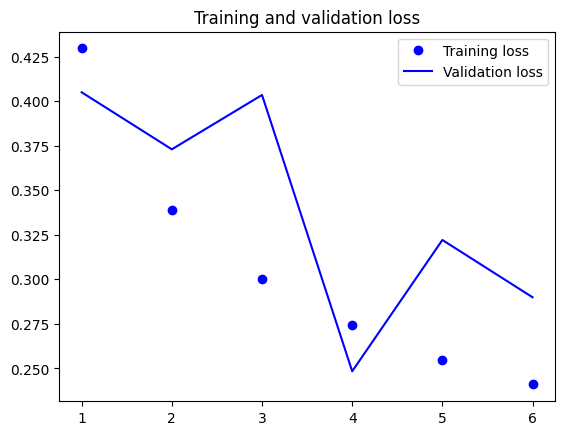

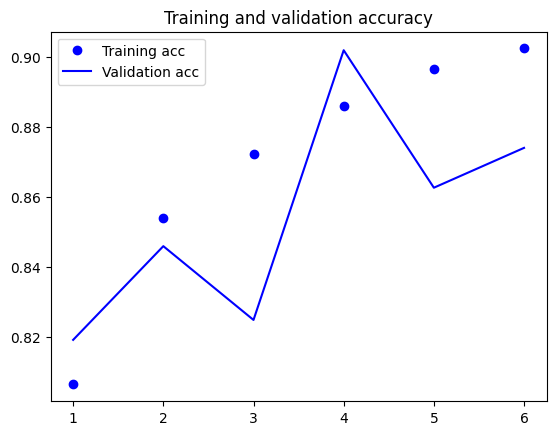

<Figure size 640x480 with 0 Axes>

In [45]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

In [3]:
predictions = model.predict_generator(test_gen, steps=len(df_val), verbose=1)

NameError: name 'test_gen' is not defined

In [47]:
predictions.shape

(16000, 2)

In [2]:
from keras.models import load_model
model = load_model('/home/hello/Documents/coding/CANCER/cancer_site_project/applications/diagnostics/saved_models/model.h5')

2023-02-17 00:43:15.680903: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-17 00:43:15.681154: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-17 00:43:15.681216: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-02-17 00:43:15.681253: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-02-17 00:43:15.681285: W tensorflow/c

In [49]:
df_preds = pd.DataFrame(predictions, columns=['no_met_tissue', 'has_met_tissue'])

df_preds.head()

,no_met_tissue,has_met_tissue
0,0.999997,0.000002
1,0.998948,0.001052
2,0.962702,0.037298
3,0.999459,0.000541
4,0.990696,0.009304


In [ ]:
model.predict(train_gen)

In [50]:
# Get the true labels
y_true = test_gen.classes

# Get the predicted labels as probabilities
y_pred = df_preds['has_met_tissue']

In [56]:
model.save('model.h5')

In [51]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_true, y_pred)

0.9668247500000001

In [52]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [58]:

model.save("model")

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


In [59]:
model.save("model.h5")